## **Import Libraries**


In [ ]:
## Conection with Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

##**Training with Initial Data**

In [ ]:
# Define the directories for the training, validation, and testing data:
train_dir = '/content/drive/MyDrive/project_phase_2/Leaf_Disease_WPP/train/'
val_dir = '/content/drive/MyDrive/project_phase_2/Leaf_Disease_WPP/val/'
test_dir = '/content/drive/MyDrive/project_phase_2/Leaf_Disease_WPP/test/'

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the data generators for the training, validation, and testing data:
batch_size = 128
img_dims = 224

train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(224, 224),
                                                    batch_size=batch_size, class_mode='categorical')

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(val_dir, target_size=(224, 224),
                                                batch_size=batch_size, class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(224, 224),
                                                  batch_size=batch_size, class_mode='categorical')

Found 3082 images belonging to 4 classes.
Found 385 images belonging to 4 classes.
Found 385 images belonging to 4 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [ ]:
inception_model = InceptionV3(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
for layer in inception_model.layers:
    layer.trainable = False

x = tf.keras.layers.GlobalAveragePooling2D()(inception_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')(x)

model_4 = tf.keras.models.Model(inception_model.input, x)
model_4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 5
history_4 = model_4.fit(train_generator, epochs=epochs,steps_per_epoch=train_generator.samples // batch_size, 
                        validation_data=val_generator,validation_steps=val_generator.samples // batch_size)

#model_4.save('/content/drive/MyDrive/project_phase_2/models/Inceptionv3_model_4.h5')
test_loss_4, test_acc_4 = model_4.evaluate(test_generator)
print('Test accuracy:', test_acc_4)

87910968/87910968 [==============================] - 1s 0us/step
Epoch 1/5
24/24 [==============================] - 756s 31s/step - loss: 0.7209 - accuracy: 0.7268 - val_loss: 0.4077 - val_accuracy: 0.8428
Epoch 2/5
24/24 [==============================] - 478s 20s/step - loss: 0.3152 - accuracy: 0.8659 - val_loss: 0.3714 - val_accuracy: 0.8584
Epoch 3/5
24/24 [==============================] - 483s 20s/step - loss: 0.3859 - accuracy: 0.8468 - val_loss: 0.3064 - val_accuracy: 0.8762
Epoch 4/5
24/24 [==============================] - 476s 20s/step - loss: 0.3068 - accuracy: 0.8739 - val_loss: 0.3841 - val_accuracy: 0.8467
Epoch 5/5
4/4 [==============================] - 90s 24s/step - loss: 0.2251 - accuracy: 0.90846
Test accuracy: 0.908467520236969



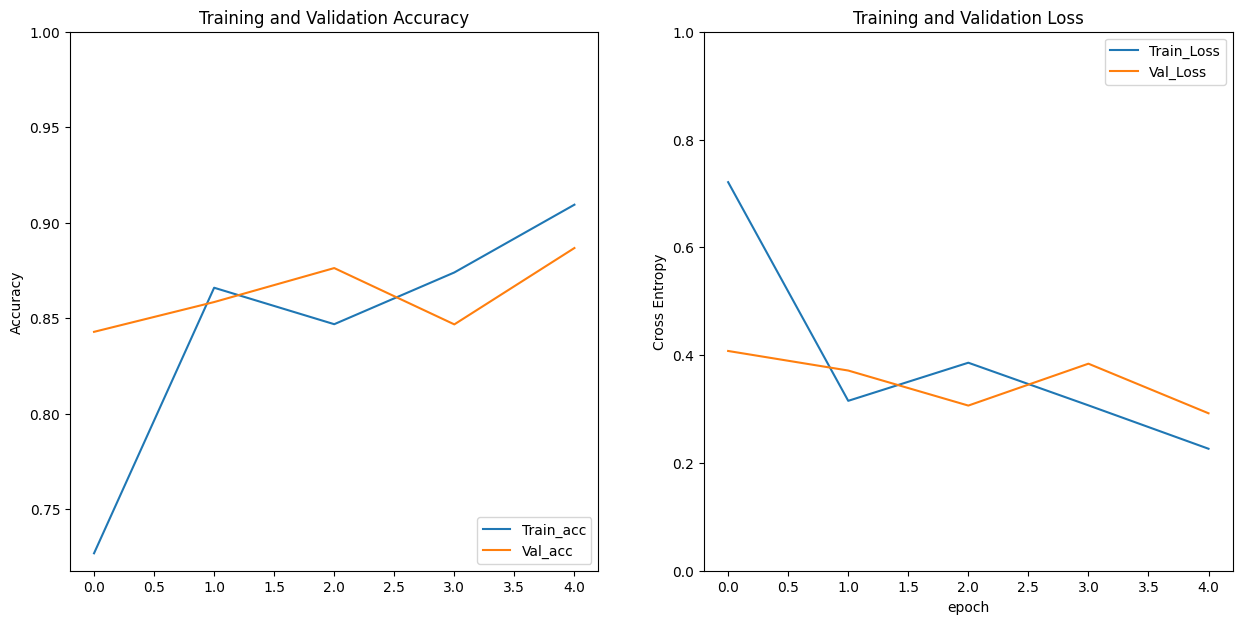

In [ ]:
### Loss and accuracy plot
acc_mob = history_4.history['accuracy']
val_acc_mob = history_4.history['val_accuracy']

loss_mob = history_4.history['loss']
val_loss_mob = history_4.history['val_loss']

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(acc_mob, label='Train_acc')
plt.plot(val_acc_mob, label='Val_acc')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss_mob, label='Train_Loss')
plt.plot(val_loss_mob, label='Val_Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
input_test = test_dir
labels = os.listdir(input_test)
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_dims, img_dims)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [ ]:
test_set_ = get_data(input_test)

## X and y test
X_test, y_test = [],[]
for feature, labels in test_set_:
  X_test.append(feature)
  y_test.append(labels)
## Convert the data in arrays 
X_test = np.array(X_test) / 255
y_test = np.array(y_test)

<ipython-input-8-e3d239c42c2b>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [ ]:
y_pred = np.argmax(model_4.predict(X_test), axis = -1)

13/13 [==============================] - 49s 4s/step


       
                precision    recall  f1-score   support

        Blight       0.81      0.80      0.80        99
   Common_Rust       0.98      0.97      0.97       119
Gray_Leaf_Spot       0.75      0.72      0.73        51
       Healthy       0.95      0.98      0.96       116

      accuracy                           0.90       385
     macro avg       0.87      0.86      0.86       385
  weighted avg       0.90      0.90      0.90       385

Accuracy: 0.90%


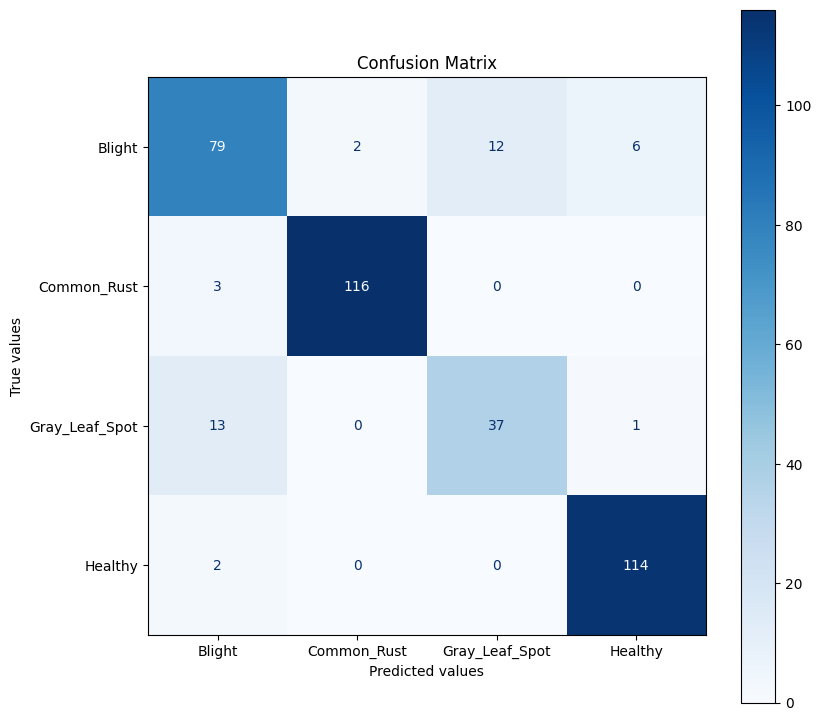

In [ ]:
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report

#print("CONFUSION MATRIX of training data ------------------------------")
fig, ax = plt.subplots(figsize=(9,9))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap = 'Blues', ax = ax)
ax.set_xlabel("Actual values")
ax.set_ylabel("Predicted Values")
class_names = ["Blight", "Common_Rust","Gray_Leaf_Spot", "Healthy"]
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)

## Accuracy and F1-Score
print(classification_report(y_test,y_pred, target_names = class_names))
acc_x = accuracy_score(y_test, y_pred)

print(f'Accuracy: {round(acc_x, 3)}%')

## **Prepare Data For Model Training and Validation**

In [ ]:
# Define the directories for the training, validation, and testing data:
train_dir = '/content/drive/MyDrive/project_phase_2/Leaf_Disease_Aug/train/'
val_dir = '/content/drive/MyDrive/project_phase_2/Leaf_Disease_Aug/val/'
test_dir = '/content/drive/MyDrive/project_phase_2/Leaf_Disease_Aug/test/'

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the data generators for the training, validation, and testing data:
batch_size = 128
img_dims = 224

train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(224, 224),
                                                    batch_size=batch_size, class_mode='categorical')

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(val_dir, target_size=(224, 224),
                                                batch_size=batch_size, class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(224, 224),
                                                  batch_size=batch_size, class_mode='categorical')

Found 7622 images belonging to 4 classes.
Found 951 images belonging to 4 classes.
Found 945 images belonging to 4 classes.


## **Aug Data Training**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [ ]:
inception_model = InceptionV3(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
for layer in inception_model.layers:
    layer.trainable = False

x = tf.keras.layers.GlobalAveragePooling2D()(inception_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')(x)

model_4 = tf.keras.models.Model(inception_model.input, x)
model_4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 5
history_4 = model_4.fit(train_generator, epochs=epochs,steps_per_epoch=train_generator.samples // batch_size, 
                        validation_data=val_generator,validation_steps=val_generator.samples // batch_size)

model_4.save('/content/drive/MyDrive/project_phase_2/models/Inceptionv3_model_4.h5')
test_loss_4, test_acc_4 = model_4.evaluate(test_generator)
print('Test accuracy:', test_acc_4)

87910968/87910968 [==============================] - 1s 0us/step
Epoch 1/5
39/39 [==============================] - 1226s 31s/step - loss: 0.8161 - accuracy: 0.6813 - val_loss: 0.3230 - val_accuracy: 0.8945
Epoch 2/5
39/39 [==============================] - 690s 18s/step - loss: 0.3798 - accuracy: 0.8488 - val_loss: 0.2695 - val_accuracy: 0.8945
Epoch 3/5
39/39 [==============================] - 690s 18s/step - loss: 0.3116 - accuracy: 0.8780 - val_loss: 0.1898 - val_accuracy: 0.9336
Epoch 4/5
39/39 [==============================] - 683s 18s/step - loss: 0.2643 - accuracy: 0.8979 - val_loss: 0.2003 - val_accuracy: 0.9238
Epoch 5/5
5/5 [==============================] - 149s 33s/step - loss: 0.1875 - accuracy: 0.9223
Test accuracy: 0.9223454594612122


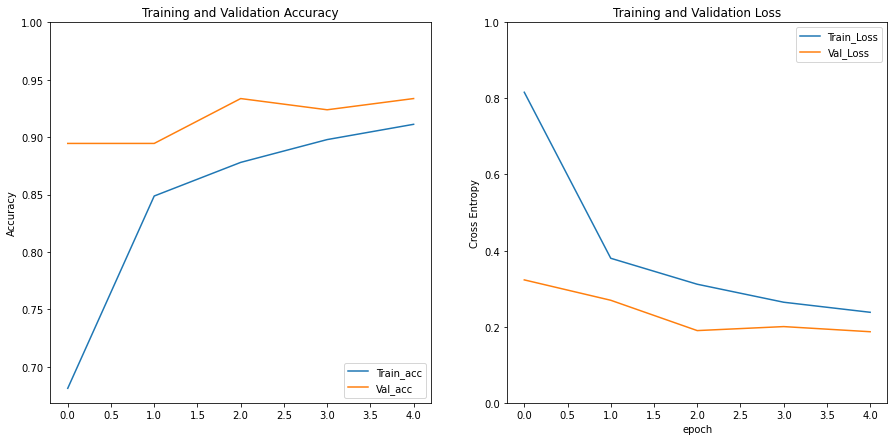

In [ ]:
### Loss and accuracy plot
acc_mob = history_4.history['accuracy']
val_acc_mob = history_4.history['val_accuracy']

loss_mob = history_4.history['loss']
val_loss_mob = history_4.history['val_loss']

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(acc_mob, label='Train_acc')
plt.plot(val_acc_mob, label='Val_acc')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss_mob, label='Train_Loss')
plt.plot(val_loss_mob, label='Val_Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
input_test = test_dir
labels = os.listdir(input_test)
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_dims, img_dims)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [ ]:
test_set_ = get_data(input_test)

## X and y test
X_test, y_test = [],[]
for feature, labels in test_set_:
  X_test.append(feature)
  y_test.append(labels)
## Convert the data in arrays 
X_test = np.array(X_test) / 255
y_test = np.array(y_test)

<ipython-input-9-e3d239c42c2b>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [ ]:
y_pred = np.argmax(model_4.predict(X_test), axis = -1)

20/20 [==============================] - 78s 4s/step


                precision    recall  f1-score   support

        Blight       0.86      0.85      0.85       158
   Common_Rust       0.99      0.97      0.98       155
Gray_Leaf_Spot       0.85      0.86      0.86       159
       Healthy       0.98      0.99      0.99       159

      accuracy                           0.92       631
     macro avg       0.92      0.92      0.92       631
  weighted avg       0.92      0.92      0.92       631

Accuracy: 0.919%


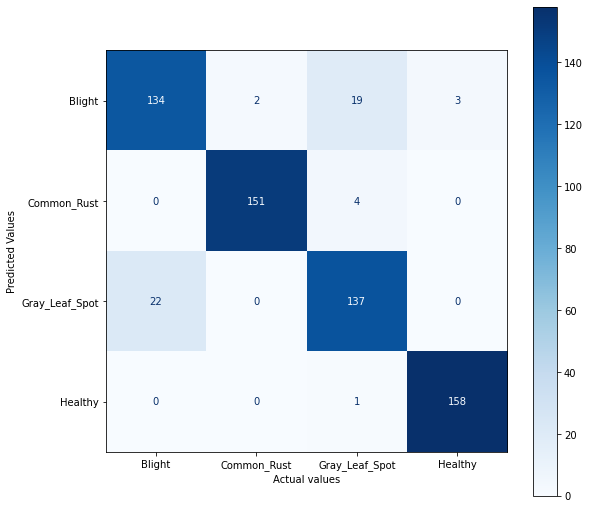

In [ ]:
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report

#print("CONFUSION MATRIX of training data ------------------------------")
fig, ax = plt.subplots(figsize=(9,9))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap = 'Blues', ax = ax)
ax.set_xlabel("Actual values")
ax.set_ylabel("Predicted Values")
class_names = ["Blight", "Common_Rust","Gray_Leaf_Spot", "Healthy"]
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)

## Accuracy and F1-Score
print(classification_report(y_test,y_pred, target_names = class_names))
acc_x = accuracy_score(y_test, y_pred)

print(f'Accuracy: {round(acc_x, 3)}%')

##Comparision

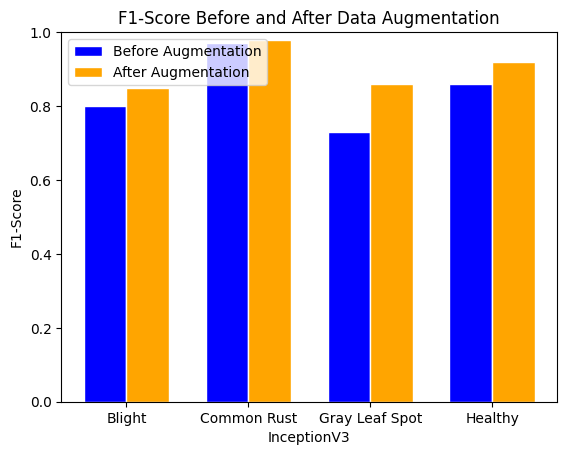

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the labels for the x-axis
labels = ['Blight', 'Common Rust', 'Gray Leaf Spot','Healthy']

# Define the f1 scores for each label before data augmentation
before_augmentation = [0.80, 0.97, 0.73, 0.96]

# Define the f1 scores for each label after data augmentation
after_augmentation = [0.85, 0.98, 0.86, 0.99]

# Set the width of the bars
bar_width = 0.35

# Set the positions of the bars on the x-axis
r1 = np.arange(len(before_augmentation))
r2 = [x + bar_width for x in r1]

# Plot the bars for f1 scores before and after data augmentation
plt.bar(r1, before_augmentation, color='blue', width=bar_width, edgecolor='white', label='Before Augmentation')
plt.bar(r2, after_augmentation, color='orange', width=bar_width, edgecolor='white', label='After Augmentation')

# Add x-axis labels and title
plt.xlabel('InceptionV3')
plt.ylabel('F1-Score')
plt.title('F1-Score Before and After Data Augmentation')

# Add x-axis tick labels
plt.xticks([r + bar_width/2 for r in range(len(before_augmentation))], labels)
plt.ylim(0,1)
# Add legend
plt.legend()

# Show the plot
plt.show()